# Tutorial using custom genome on the PBMC bulk ATAC-seq

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="anndata")
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import json
import csv
import re
from sklearn.preprocessing import OneHotEncoder

In [2]:
def density_plot(x, y, logx=False, logy=False):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    # 2D histogram binning to estimate density
    bins = 10000  # tune this for resolution/performance
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    
    # Assign each point a density based on its bin
    x_bin = np.searchsorted(xedges, x, side='right') - 1
    y_bin = np.searchsorted(yedges, y, side='right') - 1
    
    # Clip out-of-bound indices
    mask = (x_bin >= 0) & (x_bin < bins) & (y_bin >= 0) & (y_bin < bins)
    density = np.zeros_like(x, dtype=float)
    density[mask] = np.log10(hist[x_bin[mask], y_bin[mask]])
    
    # Sort by density for better visual effect
    idx = density.argsort()
    x, y, density = x[idx], y[idx], density[idx]
    x = np.log10(x) if logx else x
    y = np.log10(y) if logy else y
    sns.scatterplot(x=x,y=y,hue=density,linewidth=0, s=1, palette='viridis')

Most of the content is the same as the PBMC_bulkATAC tutorial, please refer to that one for more detailed explanation. Here, we'll just focus on how we can use the custom genome.

In [3]:
main_dir = '/ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/'
work_dir = f'{main_dir}/seq2print'
if not os.path.exists(work_dir):
    os.system("mkdir -p " + work_dir)
frag_dir = f'{main_dir}/fragments'
if not os.path.exists(frag_dir):
    os.system("mkdir -p " + frag_dir)

In [4]:
# Download the fragments files of bulk samples from our Zenodo repository https://zenodo.org/records/14866808 using the code below
samples = ["Bcell_0", "Bcell_1", "Monocyte_0", "Monocyte_1", "Tcell_0", "Tcell_1"]
for sample in samples:
    link_prefix = "https://zenodo.org/records/14866808/files/PBMC_bulk_ATAC_tutorial_"
    link_suffix = "_frags.tsv.gz?download=1"
    os.system(f"wget -O {frag_dir}/{sample}_frags.tsv.gz {link_prefix}{sample}{link_suffix}")

--2025-04-08 13:54:08--  https://zenodo.org/records/14866808/files/PBMC_bulk_ATAC_tutorial_Bcell_0_frags.tsv.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92267715 (88M) [application/octet-stream]
Saving to: ‘/ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Bcell_0_frags.tsv.gz’

     0K .......... .......... .......... .......... ..........  0%  261K 5m45s
..... ..........  0%  521K 4m19s........ .....
   100K .......... .......... .......... .......... ..........  0%  831K 3m29s
   150K .......... .......... .......... .......... ..........  0%  515K 3m20s
..  0%  521K 3m14s .......... .......... .......... ........
   250K .......... .......... .......... .......... ..........  0%  100M 2m42s
   300K .......... .......... .......... .......... ..........  0%  522K 2m43s
   3

In [13]:
# Get the fragments files for individual samples
# Note: the fragments files should have 4 columns: chromosome, start, end, and barcode. 
# Barcode should just be sample name, which means all fragments in the same fragments file have the same barcode.
frag_files = os.listdir(frag_dir)
frag_files = [i for i in frag_files if re.search("frags.tsv.gz", i) is not None]
frag_files = sorted([os.path.join(frag_dir, i) for i in frag_files])
samples = ["_".join(re.split("[/_\\.]", i)[11:13]) for i in frag_files]
samples

['fragments_Bcell',
 'fragments_Bcell',
 'fragments_Monocyte',
 'fragments_Monocyte',
 'fragments_Tcell',
 'fragments_Tcell']

## Create custom genome bias .h5 file

We now have a new function that'll take the custom genome .fa, create the bias h5 file. 
The pretained Tn5_NN_bias model can be access like this. 

In [6]:
pretrain_Tn5_bias_model = scp.datasets.pretrained_Tn5_bias_model
pretrain_Tn5_bias_model

'/ewsc/zhangruo/.cache/scprinter/Tn5_NN_model_py_v2.pt'

In this tutorial, we are still working with hg38, but just let's pretend that it's a new genome

In [7]:
scp.genome.predict_genome_tn5_bias(fa_file='/ewsc/zhangruo/.cache/scprinter/gencode_v41_GRCh38.fa.gz.decomp', # input a .fa file
                            save_name=f'{work_dir}/bias.h5',
                            tn5_model=pretrain_Tn5_bias_model,
                            context_radius=50,
                            device="cuda:0", # put "cpu" if you don't have a GPU here
                            batch_size=5000)

Predicting Tn5 bias:   0%|          | 0/194 [00:00<?, ?it/s]

It takes me ~ 10 mins on a A6000 GPU to create the bias track. But even with CPU only, it won't be that slow. 

In [8]:
scp.genome.predict_genome_tn5_bias(fa_file='/ewsc/zhangruo/.cache/scprinter/gencode_v41_GRCh38.fa.gz.decomp', # input a .fa file
                            save_name=f'{work_dir}/bias_cpu.h5',
                            tn5_model=pretrain_Tn5_bias_model,
                            context_radius=50,
                            device="cpu",
                            batch_size=5000)

Predicting Tn5 bias:   0%|          | 0/194 [00:00<?, ?it/s]

It takes me ~ 40 mins on 4 cores. Still much faster than our previous solution.

To speed up the bias track generation, we traine a new neural network model that also chieves slighly higher pearson correlation on validation set (~ 0.97) than the model we used in the paper (~0.94). But let's compare the similarity between our provided pretrained hg38 bias track and this new one. 

If you installed the new version, now hg38_v1 would be referred to the bias track we use in publication

In [4]:
old = scp.genome.hg38_v1.fetch_bias() 
new = f'{work_dir}/bias.h5'

In [5]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import h5py

max_points=3_00_000_000

model = LinearRegression()
old_all, new_all = [], []
with h5py.File(old, 'r') as f1:
    with h5py.File(new, 'r') as f2:
        for doc in scp.genome.hg38.chrom_sizes:
            v1, v2 = f1[doc][:], f2[doc][:]
            old_all.append(v1)
            new_all.append(v2)
v1 = np.concatenate(old_all)
v2 = np.concatenate(new_all)

idx = np.random.permutation(len(v1))[:max_points]
v1 = v1[idx]
v2 = v2[idx]
model.fit(v1[:, None], v2[:, None])
print (pearsonr(v1,v2))

PearsonRResult(statistic=0.9539969404985545, pvalue=0.0)


In [6]:
print()

/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


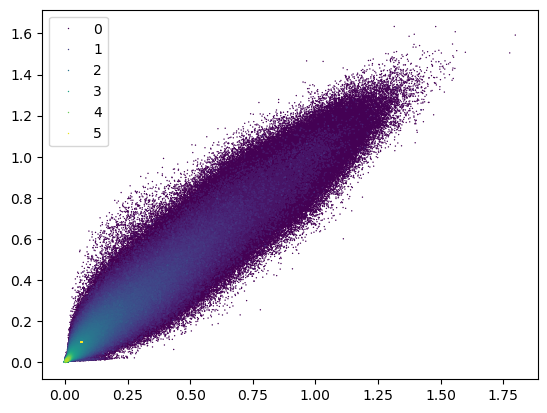

In [7]:
max_points=3_000_000
idx = np.random.permutation(len(v1))[:max_points]
v1 = v1[idx]
v2 = v2[idx]
density_plot(v1 + 1, v2 + 1, logx=True, logy=True)

Looks like we got very similar results 

## Create a custom genome object

For a custome genome track, here's what you need
- name for the genome, for custom one, name it as a "path"
- chrom_sizes as a dictionary
- gff_file: gff file you downloaded from gencode (can be a fake one if you are not using any gene-anchored function)
- fa_file: fasta file
- bias_file: the bias track computed using the above function
- blacklist_file: mapping blacklist bed file, can be a blank bed file if you have None
- bg: a tuple for ACGT background frequency, can be None
- splits: cross-validation splits by chromosomes, see below for an example

In [8]:
scp.genome.hg38_splits

[{'test': ['chr1', 'chr3', 'chr6'],
  'valid': ['chr8', 'chr20'],
  'train': ['chr2',
   'chr4',
   'chr5',
   'chr7',
   'chr9',
   'chr10',
   'chr11',
   'chr12',
   'chr13',
   'chr14',
   'chr15',
   'chr16',
   'chr17',
   'chr18',
   'chr19',
   'chr21',
   'chr22',
   'chrX',
   'chrY']},
 {'test': ['chr2', 'chr8', 'chr9', 'chr16'],
  'valid': ['chr12', 'chr17'],
  'train': ['chr1',
   'chr3',
   'chr4',
   'chr5',
   'chr6',
   'chr7',
   'chr10',
   'chr11',
   'chr13',
   'chr14',
   'chr15',
   'chr18',
   'chr19',
   'chr20',
   'chr21',
   'chr22',
   'chrX',
   'chrY']},
 {'test': ['chr4', 'chr11', 'chr12', 'chr15', 'chrY'],
  'valid': ['chr22', 'chr7'],
  'train': ['chr1',
   'chr2',
   'chr3',
   'chr5',
   'chr6',
   'chr8',
   'chr9',
   'chr10',
   'chr13',
   'chr14',
   'chr16',
   'chr17',
   'chr18',
   'chr19',
   'chr20',
   'chr21',
   'chrX']},
 {'test': ['chr5', 'chr10', 'chr14', 'chr18', 'chr20', 'chr22'],
  'valid': ['chr6', 'chr21'],
  'train': ['chr1',


In [9]:
genome_save_path = str(os.path.join(work_dir, 'custom_genome'))

In [10]:
genome = scp.genome.Genome(
    name=genome_save_path,
    chrom_sizes={'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr10': 133797422,
 'chr11': 135086622,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr19': 58617616,
 'chr20': 64444167,
 'chr21': 46709983,
 'chr22': 50818468,
 'chrX': 156040895,
 'chrY': 57227415},
    gff_file='/ewsc/zhangruo/.cache/scprinter/gencode_v41_GRCh38.gff3.gz.decomp',
    fa_file='/ewsc/zhangruo/.cache/scprinter/gencode_v41_GRCh38.fa.gz.decomp',
    bias_file=f'{work_dir}/bias.h5',
    blacklist_file='/ewsc/zhangruo/.cache/scprinter/hg38-blacklist.v2.bed.gz.decomp',
    bg=None,
    splits=scp.genome.hg38_splits)

In [11]:
# Saving the genome object for future usage and seq2PRINT
import pickle
pickle.dump(genome, open(genome_save_path, 'wb'))

## Create scprinter & preprocessing

In [14]:
printer = scp.pp.import_fragments(
                        path_to_frags=frag_files,
                        barcodes=[None] * len(frag_files), # This loads individual fragments files and combine them
                        savename=os.path.join(work_dir, 'hg38_PBMC_bulkATAC_scprinter.h5ad'),
                        genome=scp.genome.hg38_v1,
                        min_num_fragments=1000, min_tsse=7,
                        sorted_by_barcode=False, 
                        low_memory=False,
                        )

Multiple fragments files detected, it is suggested to provide sample names to avoid barcode collision
You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False


Importing fragments:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.000588901836738719, shift detected
Minimum MSE is 0.000570700312758949, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Bcell_0_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0006105708089152991, shift detected
Minimum MSE is 0.0005858127450978593, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Bcell_1_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00014365890651716197, shift detected
Minimum MSE is 0.00013537435196394527, shift dete

/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.00015927431241205087, shift detected
Minimum MSE is 0.00012580812278565858, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Monocyte_1_frags.tsv.gz


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Minimum MSE is 0.0009609965508522448, shift detected
Minimum MSE is 0.0009702142313345203, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Tcell_0_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Minimum MSE is 0.0009313237569752904, shift detected
Minimum MSE is 0.0008725416713521441, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Tcell_1_frags.tsv.gz


  0%|          | 0/6 [00:00<?, ?it/s]

/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

start transferring insertions


In [15]:
printer_custom = scp.pp.import_fragments(
                        path_to_frags=frag_files,
                        barcodes=[None] * len(frag_files), # This loads individual fragments files and combine them
                        savename=os.path.join(work_dir, 'custom_PBMC_bulkATAC_scprinter.h5ad'),
                        genome=genome,
                        min_num_fragments=1000, min_tsse=7,
                        sorted_by_barcode=False, 
                        low_memory=False,
                        )

Multiple fragments files detected, it is suggested to provide sample names to avoid barcode collision
You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False


Importing fragments:   0%|          | 0/6 [00:00<?, ?it/s]

Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0006053778272894771, shift detected
Minimum MSE is 0.0006163266494225867, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Bcell_0_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format
Minimum MSE is 0.0006265457553984244, shift detected
Minimum MSE is 0.0006144101983508013, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Bcell_1_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Minimum MSE is 0.00015707809519852097, shift detected
Minimum MSE is 0.00012808848825309163, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Monocyte_0_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Minimum MSE is 0.0001351764017021984, shift detected
Minimum MSE is 0.00011339770469122991, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Monocyte_1_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Minimum MSE is 0.0009116686778313209, shift detected
Minimum MSE is 0.0010305445879816096, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Tcell_0_frags.tsv.gz
Detecting the shift in the paired end fragments file
If you think the above message is wrong, please check the input file format


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

Minimum MSE is 0.000984404632386068, shift detected
Minimum MSE is 0.0009497587082732638, shift detected
detected plus_shift and minus_shift are 4 -5 for /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//fragments/Tcell_1_frags.tsv.gz


  0%|          | 0/6 [00:00<?, ?it/s]

/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

start transferring insertions
creating bias bigwig (runs for new bias h5 file)


  0%|          | 0/194 [00:00<?, ?it/s]

bias bigwig created


## Call peaks on the fragments in a preset for training seq2PRINT model

In [16]:
# Call peaks, this set of peaks are recommended to train seq2PRINT model
scp.pp.call_peaks(printer=printer,
                  frag_file=frag_files,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['all'],
                  preset='seq2PRINT',
                  overwrite=False)

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/seq2print_cleaned_narrowPeak.bed', 
                     sep='\t', header=False, index=False)


running macs2 with macs2 callpeak --nomodel -t /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_1_frags.tsv.gz --outdir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/hg38_PBMC_bulkATAC_scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01


INFO  @ Tue, 08 Apr 2025 15:52:49: 
# Command line: callpeak --nomodel -t /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_1_frags.tsv.gz --outdir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/hg38_PBMC_bulkATAC_scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01
# ARGUMENTS LIST:
# name = all
# format = BEDPE
# ChIP-seq file = ['/ewsc/zhangru

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 299137 peaks unresolved 295927 peaks selected
round: 2 147 peaks unresolved 143 peaks selected
finish clearing
finish sorting
finished summary


/tmp/ipykernel_3517451/808499759.py:10: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])


In [17]:
# Call peaks using chromvar preset, this set of peak are recommended to be use as cell x peak for scATAC-seq data, or analysis
scp.pp.call_peaks(printer=printer,
                  frag_file=frag_files,
                  cell_grouping=[None], # here we call peaks on the cells that are included in the final analyses
                  group_names=['chromvar_all'],
                  preset='chromvar',
                  overwrite=False)

# Fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/regions.bed', 
                     sep='\t', header=False, index=False)

running macs2 with macs2 callpeak --nomodel -t /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_1_frags.tsv.gz --outdir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/hg38_PBMC_bulkATAC_scprinter_supp/macs2 -n chromvar_all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -q 0.01


INFO  @ Tue, 08 Apr 2025 15:56:14: 
# Command line: callpeak --nomodel -t /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Bcell_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Monocyte_1_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_0_frags.tsv.gz /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/fragments/Tcell_1_frags.tsv.gz --outdir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/hg38_PBMC_bulkATAC_scprinter_supp/macs2 -n chromvar_all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -q 0.01
# ARGUMENTS LIST:
# name = chromvar_all
# format = BEDPE
# ChIP-seq file

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 400 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 181882 peaks unresolved 116439 peaks selected
round: 2 19010 peaks unresolved 8619 peaks selected
round: 3 3980 peaks unresolved 1390 peaks selected
round: 4 1198 peaks unresolved 348 peaks selected
round: 5 403 peaks unresolved 101 peaks selected
round: 6 159 peaks unresolved 36 peaks selected
round: 7 57 peaks unresolved 15 peaks selected
round: 8 24 peaks unresolved 5 peaks selected
round: 9 6 peaks unresolved 1 peaks selected
round: 10 1 peaks unresolved 1 peaks selected
finish clearing
finish sorting
finished summary


/tmp/ipykernel_3517451/3972472059.py:10: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:])


In [18]:
# we can compare two sets of peaks with different preset
print (pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:]))

           0          1          2                3        4        5    6  \
0       chr1     816850     817850      all_peak_54  149.012  149.012  all   
1       chr1     826420     827420     all_peak_55a  21.4443  21.4443  all   
2       chr1     827037     828037     all_peak_55b  919.864  919.864  all   
3       chr1     828500     829500      all_peak_56  6.72844  6.72844  all   
4       chr1     843661     844661     all_peak_57a  6.03617  6.03617  all   
...      ...        ...        ...              ...      ...      ...  ...   
296065  chrX  155768168  155769168  all_peak_207726  6.72844  6.72844  all   
296066  chrX  155819803  155820803  all_peak_207727   27.628   27.628  all   
296067  chrX  155841026  155842026  all_peak_207728  35.3259  35.3259  all   
296068  chrX  155880773  155881773  all_peak_207729   652.67   652.67  all   
296069  chrX  155972177  155973177  all_peak_207730  2.47909  2.47909  all   

             7  
0        31030  
1        92020  
2         80

/tmp/ipykernel_3517451/2415760104.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  print (pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:]))


In [19]:
print (pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:]))

           0          1          2                          3        4  \
0       chr1     817200     817500       chromvar_all_peak_34  146.574   
1       chr1     827387     827687      chromvar_all_peak_35b  916.665   
2       chr1     844607     844907      chromvar_all_peak_36c  12.9478   
3       chr1     858011     858311       chromvar_all_peak_37  13.8403   
4       chr1     865660     865960       chromvar_all_peak_38  104.183   
...      ...        ...        ...                        ...      ...   
126950  chrX  155632509  155632809   chromvar_all_peak_117522  48.6245   
126951  chrX  155767443  155767743  chromvar_all_peak_117523a  21.4989   
126952  chrX  155820153  155820453   chromvar_all_peak_117524  25.6312   
126953  chrX  155841376  155841676   chromvar_all_peak_117525  33.2717   
126954  chrX  155881123  155881423   chromvar_all_peak_117526  649.668   

              5             6      7  
0       146.574  chromvar_all  25181  
1       916.665  chromvar_all   7

/tmp/ipykernel_3517451/2938188741.py:1: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  print (pd.DataFrame(printer.uns["peak_calling"]['chromvar_all_cleaned'][:]))


## Now let's compare the footprinting results using custom genome

So together with the new bias model, we also have a new set of dispersion model trained for footprinting. The new dispersion model is trained on lower coverage data than the previous version, aiming to adapt to lower coverage ATAC-seq data

Because the new bias model is super correlated with the old one, it should be fine using them interchangably. 
But let's compare. 

In [20]:
# this is the function to load old dispersion model
printer.load_disp_model(scp.datasets.pretrained_dispersion_model_v1)

#this is the function to load the new dispersion model
printer.load_disp_model(scp.datasets.pretrained_dispersion_model_v2)

# the default would now be the new dispersion model
printer.load_disp_model()
printer.load_disp_model()

In [21]:
regions = scp.utils.regionparser(f'{work_dir}/regions.bed', width=1000)
regions

Chromosome      Start        End                          3         4  \
0            chr1     816850     817850       chromvar_all_peak_34  146.5740   
1            chr1     827037     828037      chromvar_all_peak_35b  916.6650   
2            chr1     844257     845257      chromvar_all_peak_36c   12.9478   
3            chr1     857661     858661       chromvar_all_peak_37   13.8403   
4            chr1     865310     866310       chromvar_all_peak_38  104.1830   
...           ...        ...        ...                        ...       ...   
126950       chrX  155632159  155633159   chromvar_all_peak_117522   48.6245   
126951       chrX  155767093  155768093  chromvar_all_peak_117523a   21.4989   
126952       chrX  155819803  155820803   chromvar_all_peak_117524   25.6312   
126953       chrX  155841026  155842026   chromvar_all_peak_117525   33.2717   
126954       chrX  155880773  155881773   chromvar_all_peak_117526  649.6680   

               5             6      7  
0       146.5740  chromvar_all  25181  
1       916.6650  chromvar_all   7307  
2        12.9478  chromvar_all  76127  
3        13.8403  chromvar_all  74659  
4       104.1830  chromvar_all  30884  
...          ...           ...    ...  
126950   48.6245  chromvar_all  45815  
126951   21.4989  chromvar_all  64243  
126952   25.6312  chromvar_all  60561  
126953   33.2717  chromvar_all  54230  
126954  649.6680  chromvar_all   9600  

[126955 rows x 8 columns]

In [22]:
printer.load_disp_model(scp.datasets.pretrained_dispersion_model_v1)

In [23]:
scp.tl.get_footprint_score(
    printer,
    [list(printer.obs_names)],
    ['all'],
    regions,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=32,
    save_key="old_bias_old_disp",
    backed=True,
    overwrite=True)

estimated file size: 46.65 GB
Creating old_bias_old_disp in printer.footprintsadata
obs=groups, var=regions
10000 160
Loading insertion profiles


Submitting jobs:   0%|          | 0/12568545 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/12568545 [00:00<?, ?it/s]

In [24]:
printer.load_disp_model(scp.datasets.pretrained_dispersion_model_v2)

In [25]:
scp.tl.get_footprint_score(
    printer,
    [list(printer.obs_names)],
    ['all'],
    regions,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=32,
    save_key="old_bias_new_disp",
    backed=True,
    overwrite=True)

estimated file size: 46.65 GB
Creating old_bias_new_disp in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/12568545 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/12568545 [00:00<?, ?it/s]

In [26]:
printer_custom.load_disp_model(scp.datasets.pretrained_dispersion_model_v1)

In [27]:
scp.tl.get_footprint_score(
    printer_custom,
    [list(printer.obs_names)],
    ['all'],
    regions,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=32,
    save_key="new_bias_old_disp",
    backed=True,
    overwrite=True)

estimated file size: 46.65 GB
Creating new_bias_old_disp in printer.footprintsadata
obs=groups, var=regions
10000 160
Loading insertion profiles


Submitting jobs:   0%|          | 0/12568545 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/12568545 [00:00<?, ?it/s]

In [28]:
printer_custom.load_disp_model(scp.datasets.pretrained_dispersion_model_v2)

In [29]:
scp.tl.get_footprint_score(
    printer_custom,
    [list(printer.obs_names)],
    ['all'],
    regions,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=32,
    save_key="new_bias_new_disp",
    backed=True,
    overwrite=True)

estimated file size: 46.65 GB
Creating new_bias_new_disp in printer.footprintsadata
obs=groups, var=regions
10000 160


Submitting jobs:   0%|          | 0/12568545 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/12568545 [00:00<?, ?it/s]

In [32]:
scp.tl.get_insertions(
    printer,
    group_names=['all'],
    cell_grouping=[list(printer.obs_names)],
    regions=regions,
    save_key='coverage',
    backed=False,
    overwrite=True, summarize_func='sum')

Creating coverage in printer.insertionadata
obs=groups, var=regions


  0%|          | 0/126955 [00:00<?, ?it/s]

In [35]:
insertion_adata = printer.insertionadata['coverage'].obsm
coverage = []
for key in tqdm(printer.footprintsadata["old_bias_old_disp"].obsm.keys()):
    coverage.append(insertion_adata[key].item())
coverage = np.array(coverage)

  0%|          | 0/126955 [00:00<?, ?it/s]

In [40]:
from scipy.stats import pearsonr
r = []
for key in tqdm(printer.footprintsadata['old_bias_old_disp'].obsm.keys()):
    a = printer.footprintsadata['old_bias_old_disp'].obsm[key][..., 100:-100]
    d = printer.footprintsadata['old_bias_new_disp'].obsm[key][..., 100:-100]
    b = printer_custom.footprintsadata['new_bias_old_disp'].obsm[key][..., 100:-100]
    c = printer_custom.footprintsadata['new_bias_new_disp'].obsm[key][..., 100:-100]

    vs = [a.reshape((-1)),b.reshape((-1)),c.reshape((-1)),d.reshape((-1))]
    vs = np.array(vs)

    r.append(np.corrcoef(vs))
    

  0%|          | 0/126955 [00:00<?, ?it/s]

In [41]:
corrs_all = np.array(r)
corrs_all.shape

(126955, 4, 4)

In [42]:
names = ['old_bias_old_disp', 'old_bias_new_disp', 'new_bias_old_disp', 'new_bias_new_disp']

In [48]:
# get the mean / median /lower quantile 
mean_corr = pd.DataFrame(np.mean(corrs_all, axis=0), index=names, columns=names)
median_corr = pd.DataFrame(np.median(corrs_all, axis=0), index=names, columns=names)
low_corr = pd.DataFrame(np.quantile(corrs_all, 0.1, axis=0), index=names, columns=names)

<Axes: >

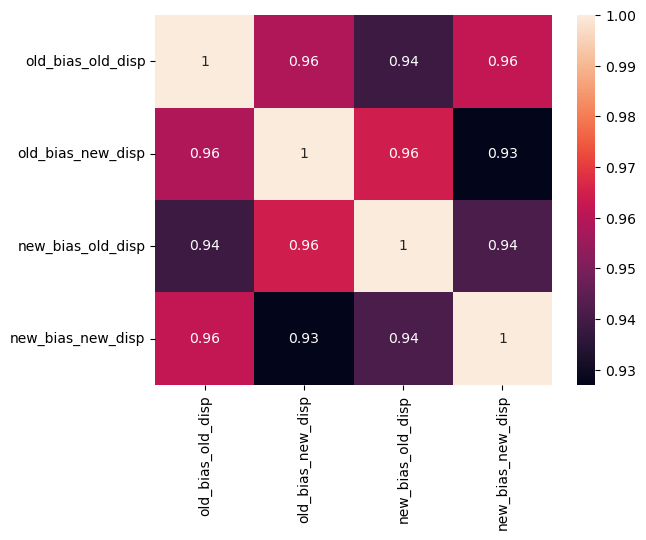

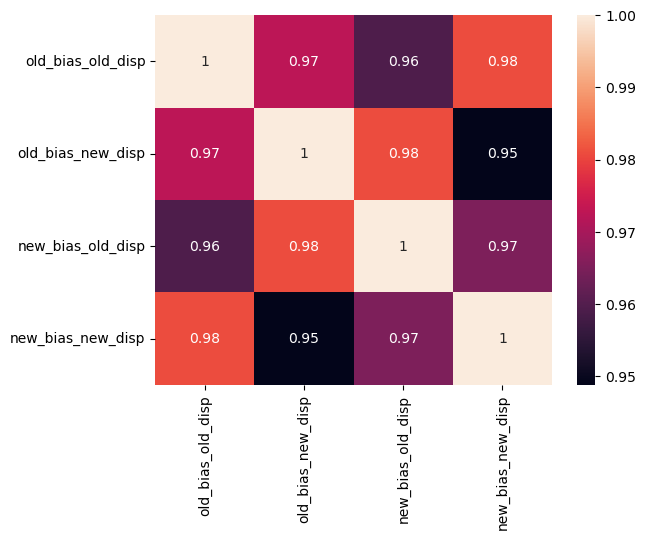

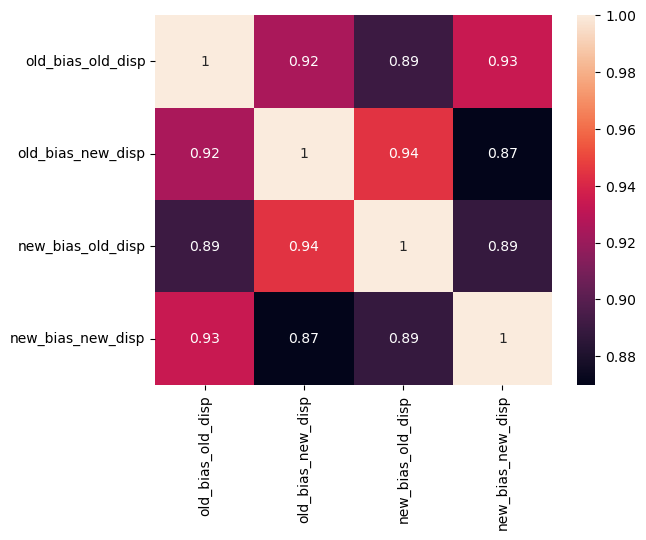

In [49]:
plt.figure()
sns.heatmap(mean_corr, annot=True)
plt.figure()
sns.heatmap(median_corr, annot=True)
plt.figure()
sns.heatmap(low_corr, annot=True)




Overall, any combination of the bias version and dispersion version is very similar to our original results (old_bias_old_disp), mean / median > 0.95 pearsonr r, bottom 10% ~ 0.9 pearson r

Now Let's visualize a few loci with relatively low corr

In [74]:
region_ids = np.array(list(printer.footprintsadata['old_bias_old_disp'].obsm.keys()))
min_corrs_to_original = np.min(corrs_all[:, 0], axis=-1) # first row is the old_bias_old_disp
avg_corrs_to_original = np.mean(corrs_all[:, 0], axis=-1) # first row is the old_bias_old_disp

# select some regions with low min correlation, and some with low average correlation
random_low_corr = list(np.random.permutation(np.where(min_corrs_to_original < np.quantile(min_corrs_to_original, 0.05))[0])[:5]) + \
                    list(np.random.permutation(np.where(avg_corrs_to_original < np.quantile(avg_corrs_to_original, 0.05))[0])[:5])

  0%|          | 0/10 [00:00<?, ?it/s]

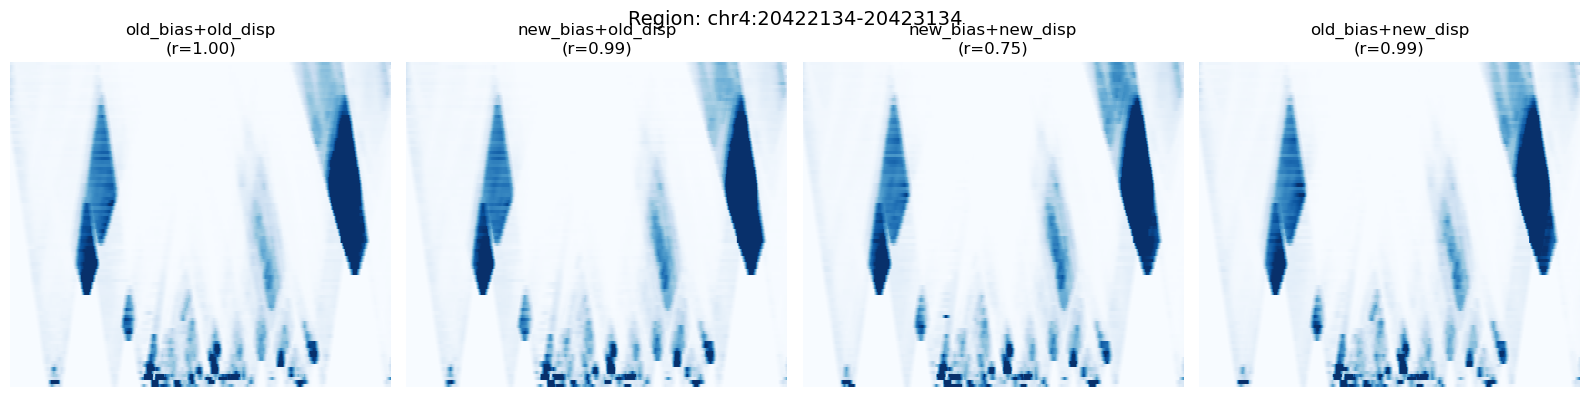

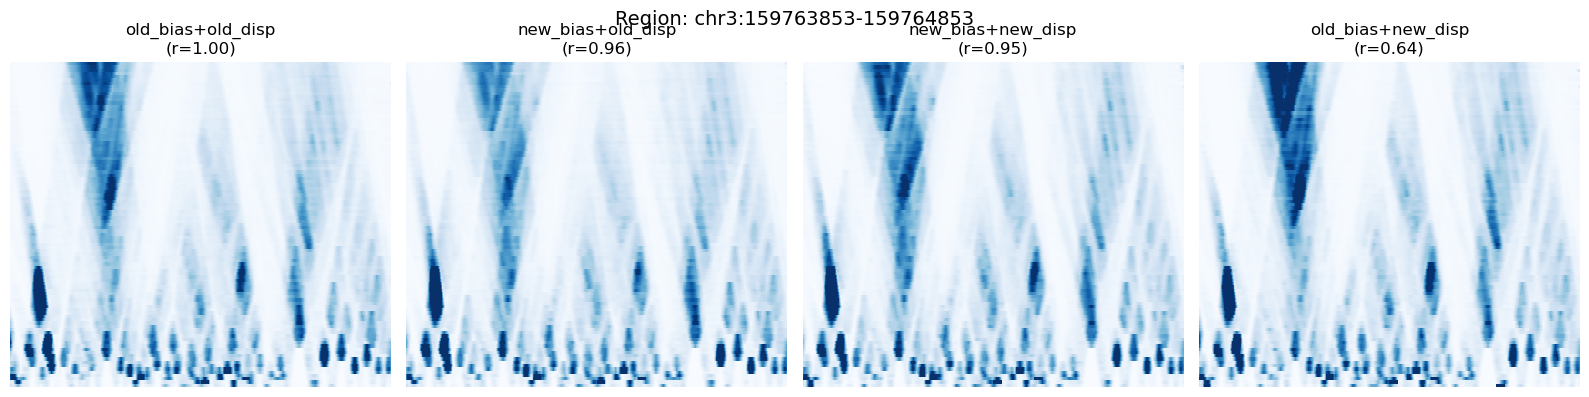

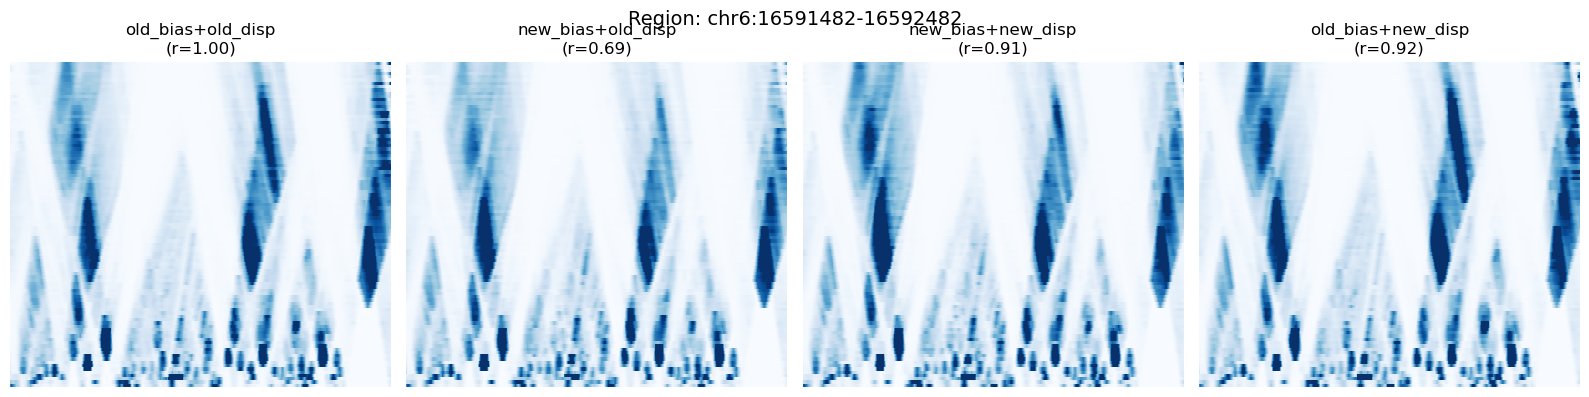

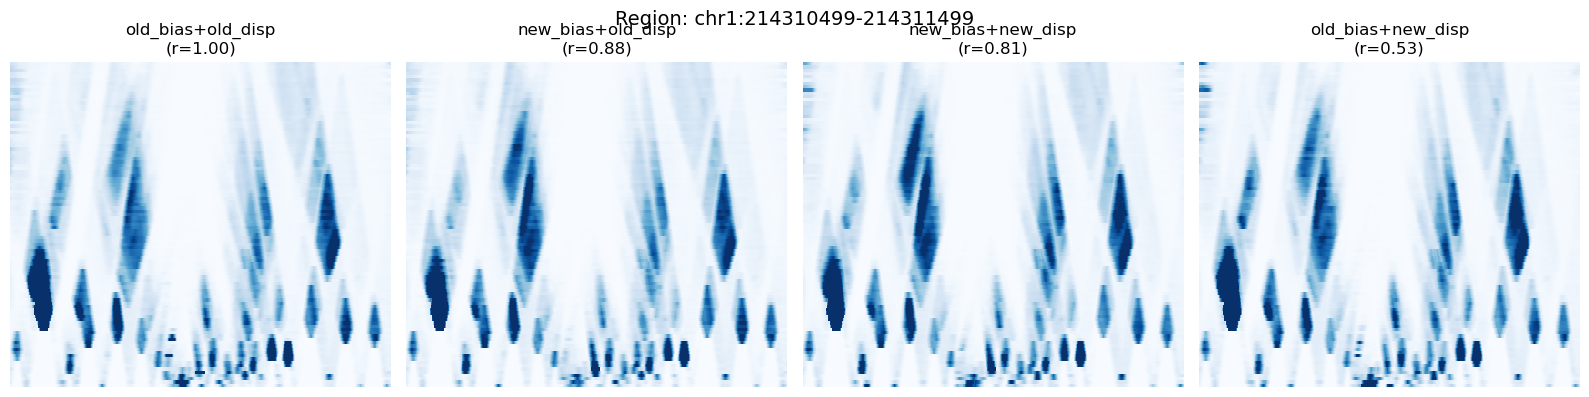

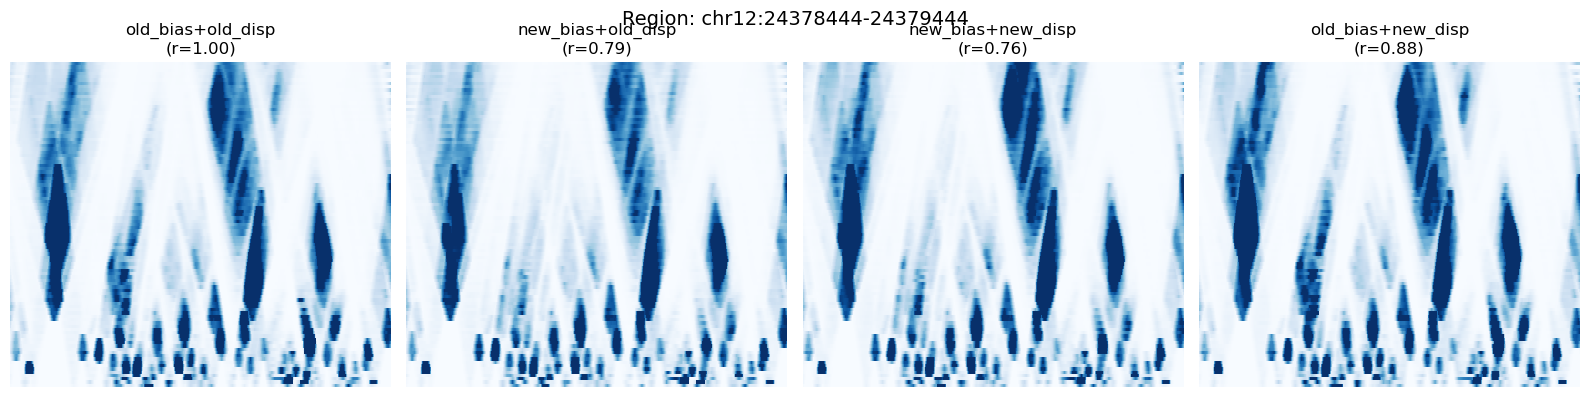

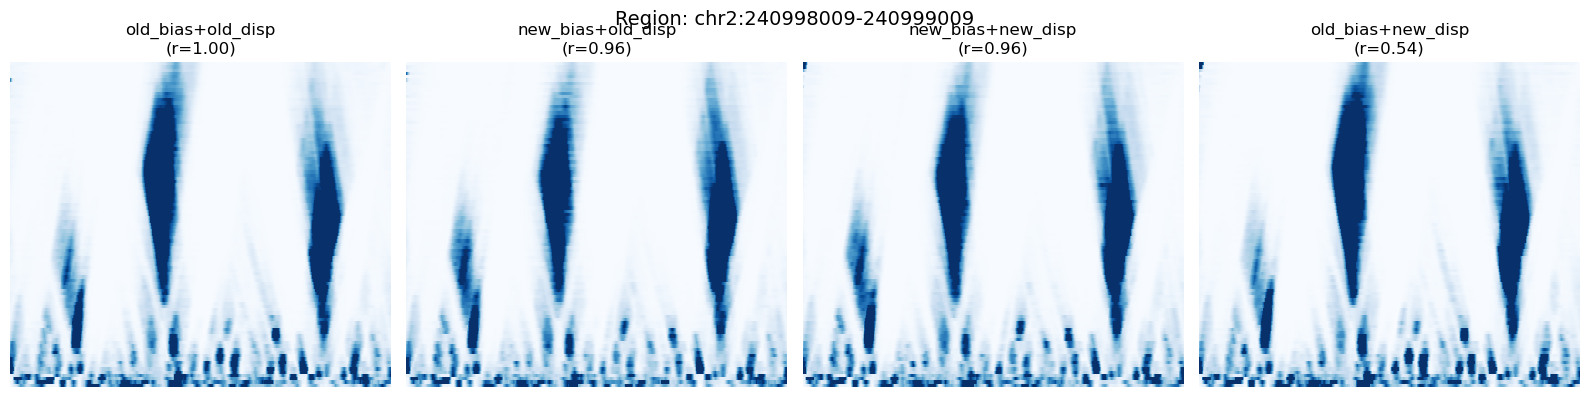

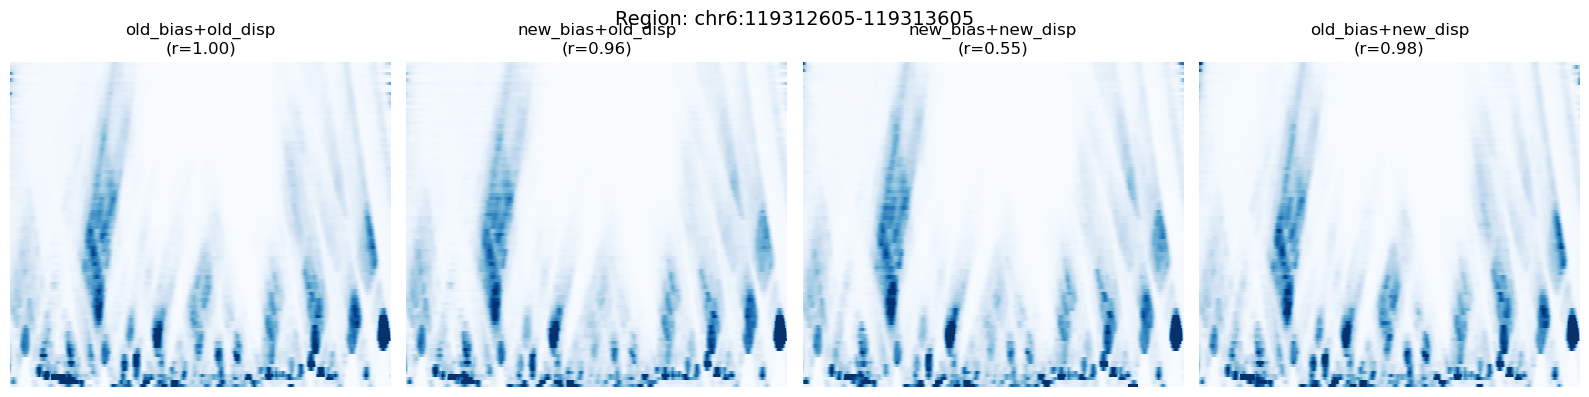

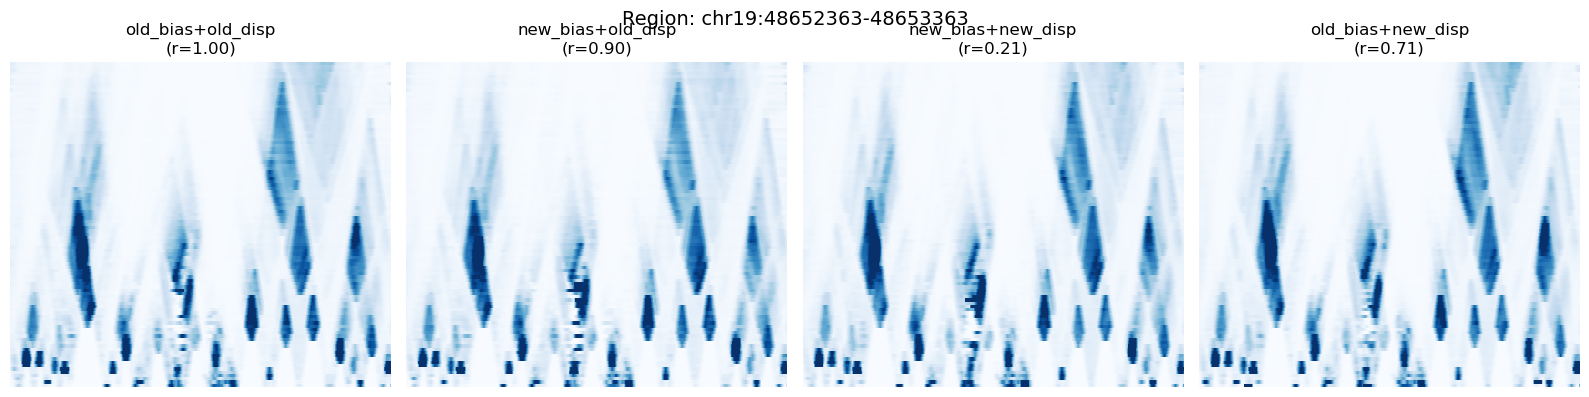

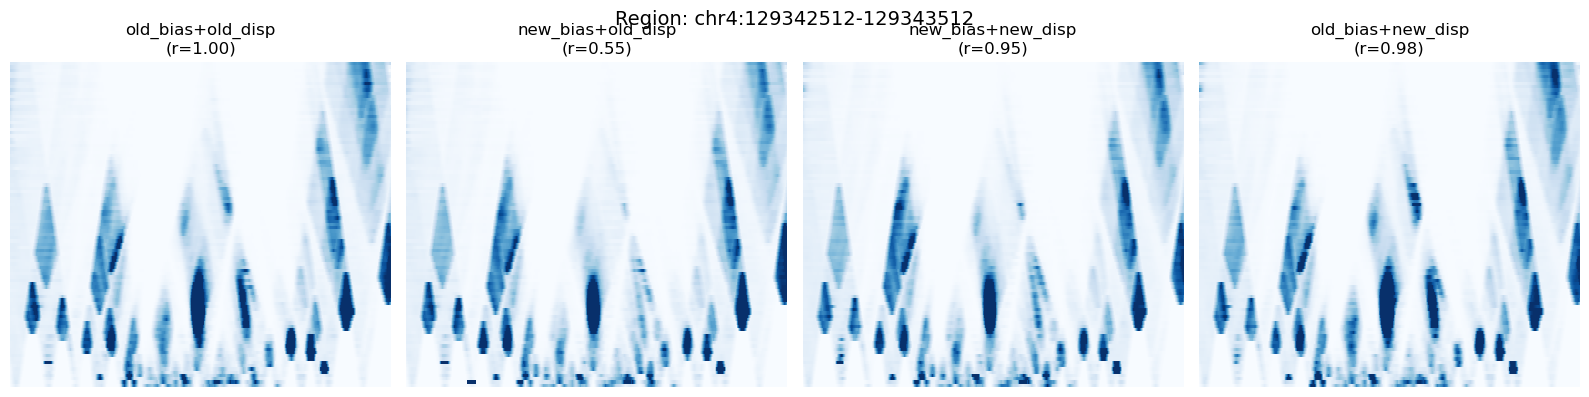

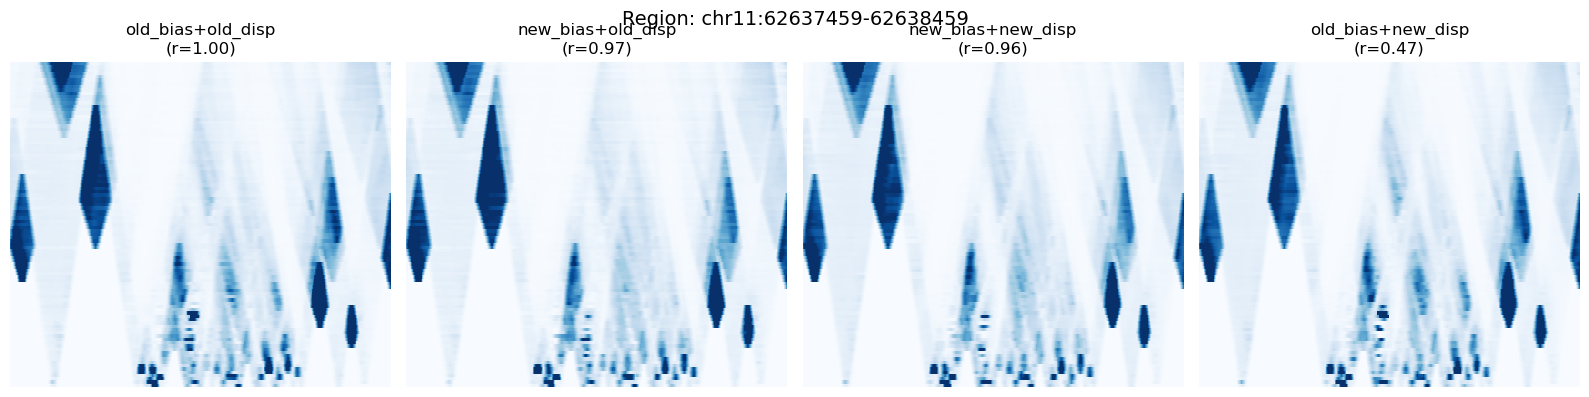

In [75]:
# Loop over regions
for key in tqdm(region_ids[random_low_corr]):
    a = printer.footprintsadata['old_bias_old_disp'].obsm[key][..., 100:-100][0][::-1]
    d = printer.footprintsadata['old_bias_new_disp'].obsm[key][..., 100:-100][0][::-1]
    b = printer_custom.footprintsadata['new_bias_old_disp'].obsm[key][..., 100:-100][0][::-1]
    c = printer_custom.footprintsadata['new_bias_new_disp'].obsm[key][..., 100:-100][0][::-1]

    # Flatten for correlation
    a_flat = a.flatten()
    b_flat = b.flatten()
    c_flat = c.flatten()
    d_flat = d.flatten()

    # Compute Pearson correlations
    corr_b = pearsonr(a_flat, b_flat)[0]
    corr_c = pearsonr(a_flat, c_flat)[0]
    corr_d = pearsonr(a_flat, d_flat)[0]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for ax, data, title in zip(
        axes,
        [a, b, c, d],
        [
            f"old_bias+old_disp\n(r=1.00)",  # self
            f"new_bias+old_disp\n(r={corr_b:.2f})",
            f"new_bias+new_disp\n(r={corr_c:.2f})",
            f"old_bias+new_disp\n(r={corr_d:.2f})"
        ]
    ):
        sns.heatmap(data, ax=ax, cmap="Blues", vmin=0, vmax=2, cbar=False)
        ax.set_title(title)
        ax.axis('off')

    fig.suptitle(f"Region: {key}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    # Save or show
    # plt.savefig(f"figs/{key}.png", dpi=150)
    plt.show()

I would say even the pixel by pixel correlation can be a bit low for some of those locus, by eye, they still look very similar to me 

Text(0.5, 1.0, 'old_bias_old_disp vs new_bias_new_disp')

/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


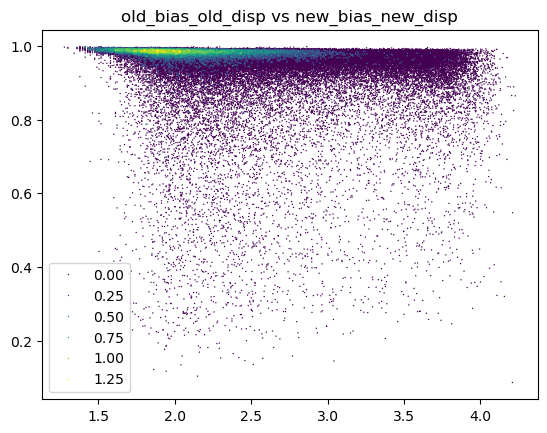

In [76]:
density_plot(x=coverage, y=corrs_all[:, 0, -1], logx=True)
plt.title('old_bias_old_disp vs new_bias_new_disp')

Overall the intended new bias + new dipersion model gives very similar results to the bias + dispersion model we used in the paper, and even you accidentally mix-n-match, it would still be fine. 

## Training seq2PRINT model for BCell_0 on old bias printer and new bias printer

In [77]:
scp.datasets.pretrained_dispersion_model_v1

'/ewsc/zhangruo/.cache/scprinter/dispersion_model_py.h5'

In [78]:
scp.datasets.pretrained_dispersion_model_v2

'/ewsc/zhangruo/.cache/scprinter/dispersion_model_py_v2.h5'

In [79]:
import json
model_configs = []
if not os.path.exists(os.path.join(work_dir, 'configs')):
    os.makedirs(os.path.join(work_dir, 'configs'))
sample = 'Bcell_0'
# For exploratory analyses we run only one fold. For publication results you can run all 5 fold for slight improvement in accuracy.
# If you want to run all five folds, add a for-loop layer "for fold in range(5)". This way each sample will have 5 models trained.
fold=0 
model_config= scp.tl.seq_model_config(printer,
                                 region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                                 cell_grouping=[sample],
                                 group_names=sample,
                                 genome=printer.genome,
                                 fold=fold, 
                                 overwrite_bigwig=False,
                                 model_name='PBMC_bulkATAC_' + sample + '_old_bias_old_disp',
                                 additional_config={
                                    "notes": "v3",
                                    "tags": ["PBMC_bulkATAC", sample, 'old_bias_old_disp'
                                        f"fold{fold}"],
                                    "dispersion_model": str(scp.datasets.pretrained_dispersion_model_v1)},
                                 path_swap=(work_dir, ''),
                                 config_save_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_old_bias_old_disp_fold{fold}.JSON')
model_configs.append(model_config)

Creating bigwig for Bcell_0


  0%|          | 0/24 [00:00<?, ?it/s]

In [81]:
model_config= scp.tl.seq_model_config(printer_custom,
                                 region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                                 cell_grouping=[sample],
                                 group_names=sample,
                                 genome=printer_custom.genome,
                                 fold=fold, 
                                 overwrite_bigwig=False,
                                 model_name='PBMC_bulkATAC_' + sample + '_new_bias_new_disp',
                                 additional_config={
                                    "notes": "v3",
                                    "tags": ["PBMC_bulkATAC", sample, 'new_bias_new_disp'
                                        f"fold{fold}"],
                                    "dispersion_model": str(scp.datasets.pretrained_dispersion_model_v2)},
                                 path_swap=(work_dir, ''),
                                 config_save_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_new_bias_new_disp_fold{fold}.JSON')
model_configs.append(model_config)

Creating bigwig for Bcell_0


  0%|          | 0/24 [00:00<?, ?it/s]

You should see an output "genome not in ['hg38', mm10'], reading as custom genome" in the custome genome model training log

In [82]:
for path in ['temp','model']:
    if not os.path.exists(os.path.join(work_dir, path)):
        os.makedirs(os.path.join(work_dir, path))


scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_old_bias_old_disp_fold{fold}.JSON',
                        temp_dir=f'{work_dir}/temp',
                        model_dir=f'{work_dir}/model',
                        data_dir=work_dir,
                        gpus=7,
                        wandb_project='scPrinter_seq_PBMC_bulkATAC_custom_genome', # wandb helps you manage loggins
                        verbose=False,
                        launch=False # launch=True, this command would launch the scripts directly,
                        # otherwise, it will just display the commands, you should copy them and run them.
                       )

scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/PBMC_bulkATAC_{sample}_new_bias_new_disp_fold{fold}.JSON',
                        temp_dir=f'{work_dir}/temp',
                        model_dir=f'{work_dir}/model',
                        data_dir=work_dir,
                        gpus=6,
                        wandb_project='scPrinter_seq_PBMC_bulkATAC_custom_genome', # wandb helps you manage loggins
                        verbose=False,
                        launch=False # launch=True, this command would launch the scripts directly,
                        # otherwise, it will just display the commands, you should copy them and run them.
                       )

CUDA_VISIBLE_DEVICES=7 seq2print_train --config /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/configs/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0.JSON --temp_dir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/temp --model_dir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model --data_dir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print --project scPrinter_seq_PBMC_bulkATAC_custom_genome --enable_wandb
CUDA_VISIBLE_DEVICES=6 seq2print_train --config /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/configs/PBMC_bulkATAC_Bcell_0_new_bias_new_disp_fold0.JSON --temp_dir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/temp --model_dir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model --data_dir /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial/

## Generate TF binding scores for each sample

In [84]:
# Now fetch models:
import wandb

# Login to your W&B account
wandb.login()

# Set your entity and project
entity = 'ruochiz'  # Replace with your W&B entity (username or team name)
project = 'scPrinter_seq_PBMC_bulkATAC_custom_genome'  # Replace with your W&B project name

# Initialize the API
api = wandb.Api()

# Get the project
runs = api.runs(f"{entity}/{project}")

pretrain_models = []
model_path_dict = {}
for run in runs:
    if run.state != 'finished':
        continue
    if 'PBMC_bulkATAC' in run.tags:
        sample = [i for i in run.tags if 'disp' in i][0]
        model_name = run.config['savename'] + '-' + run.name + '.pt'
        model_path = os.path.join(work_dir, "model", model_name)
        model_path_dict[sample] = model_path

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ruochiz to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [85]:
model_path_dict

{'old_bias_old_dispfold0': '/ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0-scarlet-glitter-3.pt',
 'new_bias_new_dispfold0': '/ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_new_bias_new_disp_fold0-vivid-snow-4.pt'}

In [86]:
regions_dict = {
    'chr11:47378230-47379030': 'SPI1', # Highly expressed in monocytes and B cells
    'chr5:140633035-140633835': 'CD14', # Monocyte marker
    'chr19:41876833-41877633': 'CD79a', # B cell marker
    'chr11:118342294-118343094': 'CD3D', # T cell marker
    'chr17:58281312-58282112': 'MPO', # Monocyte marker
    'chr16:31259594-31260394': 'ITGAM', # Expressed in myeloid cells (including monocyte)
    'chr3:39281281-39282081': 'CX3CR1', # A pretty important gene driving disease-related monocyte cell states
}

# Save example regions to a bed file
regions_df = []
for region in regions_dict:
    regions_df.append(re.split("[:-]", region))
regions_df = pd.DataFrame(regions_df)
regions_df.to_csv(f'{work_dir}/regions_test.bed',
                  sep='\t', header=False, index=False)

Below we launch the compute for TF binding scores. When we are only testing on a small number of regions or samples, we can set return_adata to be True so that the results can be returned also in an anndata object. If the number of regions or samples is big please set it to False so it doesn't take up all the memory.

Remember to check nvtop to select available GPUs using the "gpus" argument.

In [88]:
import json
sample = 'Bcell_0'
adata_tfbs_old = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/regions_test.bed',
                          gpus=[6,7], # change it to the available gpus
                          model_type='seq2print',
                          model_path=model_path_dict['old_bias_old_dispfold0'], # For now we just run on one fold but you can provide a list of paths to all 5 folds
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_old_bias_old_disp_fold{fold}.JSON', 'r')),
                          group_names=[sample],
                          verbose=False,
                          launch=True,
                          return_adata=True, # turn this as True
                          overwrite_seqattr=True,
                          post_normalize=False,
                          save_key=f'PBMC_bulkATAC_{sample}_old_bias_old_disp', # and input a save_key
                          save_path=work_dir)


adata_tfbs_new = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer_custom.genome,
                          region_path=f'{work_dir}/regions_test.bed',
                          gpus=[6,7], # change it to the available gpus
                          model_type='seq2print',
                          model_path=model_path_dict['new_bias_new_dispfold0'], # For now we just run on one fold but you can provide a list of paths to all 5 folds
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_new_bias_new_disp_fold{fold}.JSON', 'r')),
                          group_names=[sample],
                          verbose=False,
                          launch=True,
                          return_adata=True, # turn this as True
                          overwrite_seqattr=True,
                          post_normalize=False,
                          save_key=f'PBMC_bulkATAC_{sample}_new_bias_new_disp', # and input a save_key
                          save_path=work_dir)


seq2print_attr --pt /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0-scarlet-glitter-3.pt --peaks /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0_old_bias_old_disp --overwrite --write_numpy --model_norm count --silent


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 0.0 0.0
valid summits after min/max count filter 7


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 0.0 0.0
valid summits after min/max count filter 7


working on :   0%|          | 0/1 [00:00<?, ?it/s]

[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 0.0 0.0
valid summits after min/max count filter 7


working on : 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.4-8.
hypo.count.shap_hypo_0_.0.85.4-8.npz


working on : 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-4.
hypo.count.shap_hypo_0_.0.85.0-4.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0-scarlet-glitter-3.pt --peaks /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 6 7 --genome hg38 --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0_old_bias_old_disp --overwrite --write_numpy --model_norm footprint --silent


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[6, 7]
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 0.0 0.0
valid summits after min/max count filter 7


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[6]
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 0.0 0.0
valid summits after min/max count filter 7
[[None]]
[7]
signal_window 1000 dna_len 1840
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 0.0 0.0
valid summits after min/max count filter 7


working on : 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.4-8.
hypo.just_sum.shap_hypo_0-30_.0.85.4-8.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-4.
hypo.just_sum.shap_hypo_0-30_.0.85.0-4.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /ewsc/zhangruo/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /ewsc/zhangruo/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0-scarlet-glitter-3.pt_PBMC_bulkATAC_Bcell_0_old_bias_old_disp/attr.count.shap_hypo_0_.0.85.npz --seq_foot /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0-scarlet-glitter-3.pt_PB

/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

gpu 6


  0%|          | 0/7 [00:00<?, ?it/s]


(1, 7, 800)
obs=groups, var=regions
seq2print_attr --pt /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_new_bias_new_disp_fold0-vivid-snow-4.pt --peaks /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 6 7 --genome /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/custom_genome --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0_new_bias_new_disp --overwrite --write_numpy --model_norm count --silent


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[6, 7]
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom genome
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 1011.36426 1067.8242
valid summits after min/max count filter 7


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[6]
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom genome
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 1011.36426 1067.8242
valid summits after min/max count filter 7
[[None]]
[7]
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom genome
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 1011.36426 1067.8242
valid summits after min/max count filter 7


working on : 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.4-8.
hypo.count.shap_hypo_0_.0.85.4-8.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.0-4.
hypo.count.shap_hypo_0_.0.85.0-4.npz
saving attrs
using pre-calculated norm key count
filename_template {type}.count.shap_hypo_0_.0.85.
hypo.count.shap_hypo_0_.0.85.npz
seq2print_attr --pt /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_new_bias_new_disp_fold0-vivid-snow-4.pt --peaks /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/regions_test.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 6 7 --genome /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/custom_genome --decay 0.85 --save_key PBMC_bulkATAC_Bcell_0_new_bias_new_disp --overwrite --write_numpy --model_norm footprint --silent


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[6, 7]
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom genome
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 1011.36426 1067.8242
valid summits after min/max count filter 7


/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

[[None]]
[6]
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom genome
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 1011.36426 1067.8242
valid summits after min/max count filter 7
[[None]]
[7]
signal_window 1000 dna_len 1840
genome not in ['hg38', mm10'], reading as custom genome
input summits 7
valid summits after trimming edges 7
(7, 1)
coverage min max 1011.36426 1067.8242
valid summits after min/max count filter 7


working on : 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.4-8.
hypo.just_sum.shap_hypo_0-30_.0.85.4-8.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.0-4.
hypo.just_sum.shap_hypo_0-30_.0.85.0-4.npz
saving attrs
using pre-calculated norm key footprint
filename_template {type}.just_sum.shap_hypo_0-30_.0.85.
hypo.just_sum.shap_hypo_0-30_.0.85.npz
seq2print_tfbs --count_pt /ewsc/zhangruo/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /ewsc/zhangruo/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_new_bias_new_disp_fold0-vivid-snow-4.pt_PBMC_bulkATAC_Bcell_0_new_bias_new_disp/attr.count.shap_hypo_0_.0.85.npz --seq_foot /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_new_bias_new_disp_fold0-vivid-snow-4.pt_PBMC_bulkATA

/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ewsc/zhangruo/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/util

gpu 6
genome not in ['hg38', mm10'], reading as custom genome


  0%|          | 0/7 [00:00<?, ?it/s]


(1, 7, 800)
obs=groups, var=regions


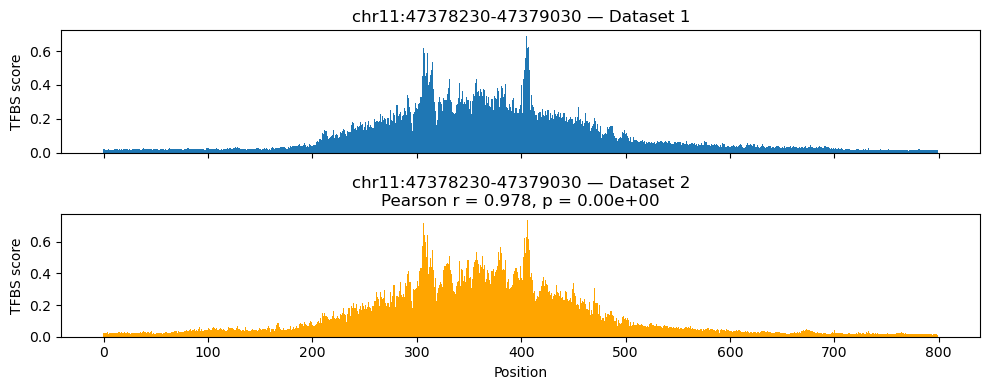

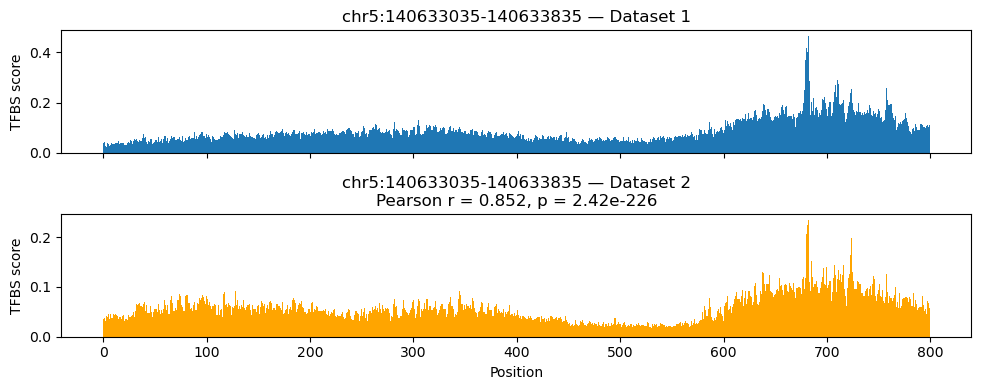

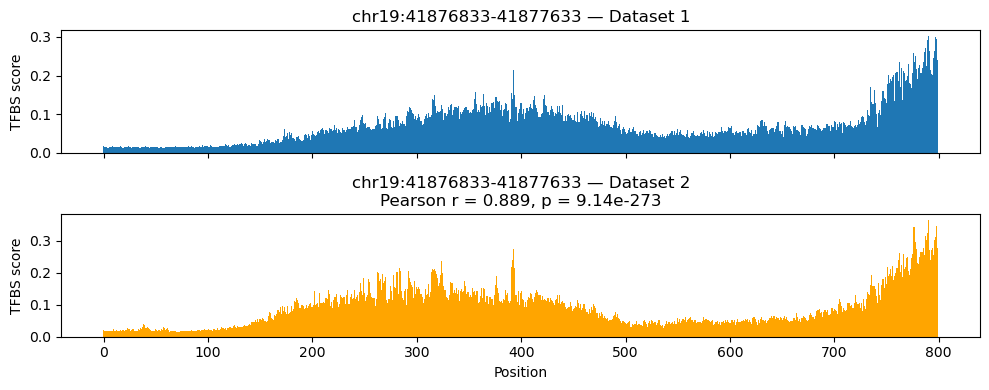

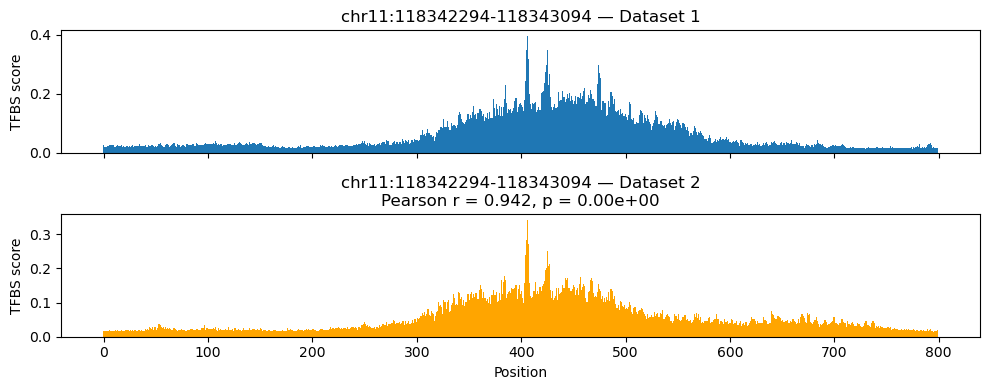

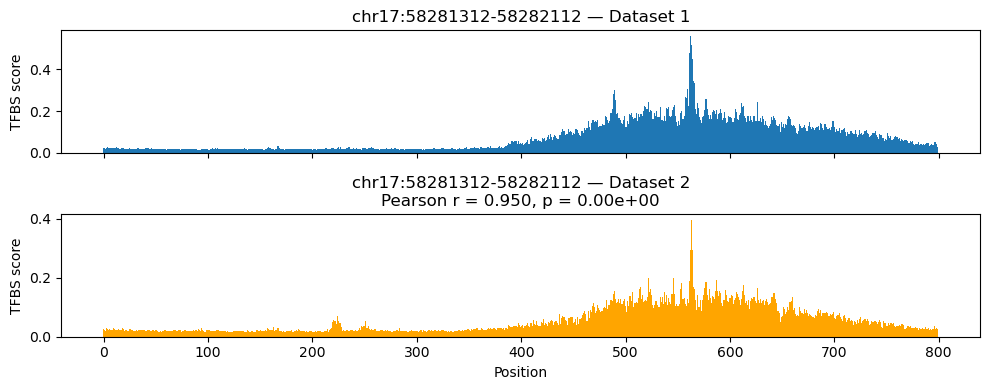

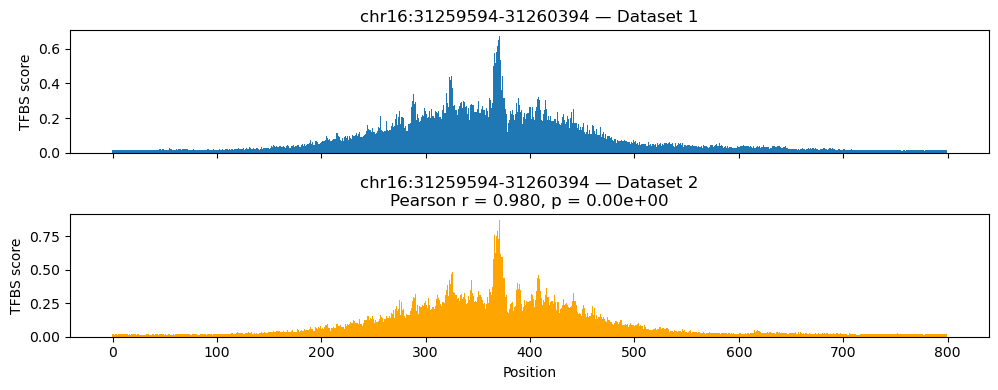

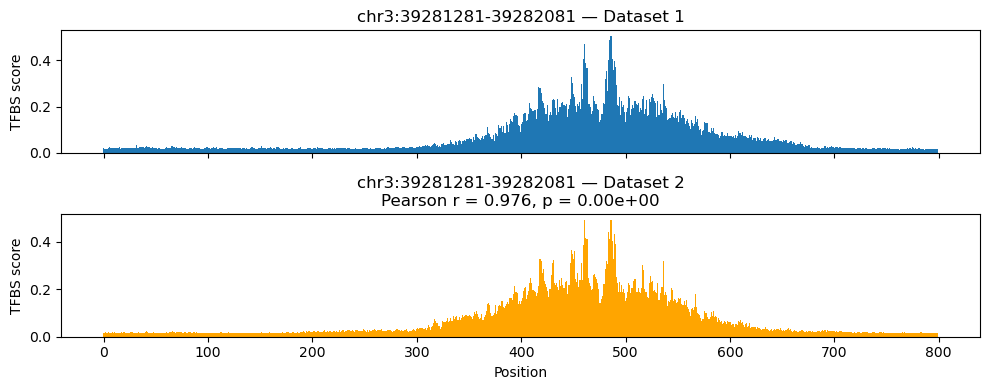

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def compare_tfbs_tracks(adata1, adata2, region_name):
    """
    Compare TFBS score tracks for a given region in two AnnData objects.
    """
    if region_name not in adata1.obsm or region_name not in adata2.obsm:
        raise ValueError(f"Region '{region_name}' not found in both AnnData.obsm")

    scores1 = np.array(adata1.obsm[region_name])[0]
    scores2 = np.array(adata2.obsm[region_name])[0]

    # Ensure same length
    if scores1.shape != scores2.shape:
        raise ValueError(f"TFBS score shapes do not match for region '{region_name}'")

    # Calculate Pearson correlation
    r, p = pearsonr(scores1, scores2)

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    axs[0].bar(np.arange(len(scores1)), scores1, width=1)
    axs[0].set_ylabel("TFBS score")
    axs[0].set_title(f"{region_name} — Dataset 1")

    axs[1].bar(np.arange(len(scores2)), scores2, color='orange', width=1)
    axs[1].set_ylabel("TFBS score")
    axs[1].set_title(f"{region_name} — Dataset 2\nPearson r = {r:.3f}, p = {p:.2e}")

    plt.xlabel("Position")
    plt.tight_layout()
    plt.show()

for region in regions_dict.keys():
    compare_tfbs_tracks(adata_tfbs_old, adata_tfbs_new, region)
    # break

The output from our DL model also seems to be pretty consistent on a few example loci

### Evaluate TF binding scores on a larger number of peaks

When we run TF binding score calculation on a large number of peaks, we set return_adata=False and instead save the results only to bigwig files. 

We first filter peaks by depth so we remove low coverage peaks and also reduce the computational load

In [93]:
# First construct a peak-by-cell matrix of ATAC counts
peak_path = f'{work_dir}/regions.bed'
adata = scp.pp.make_peak_matrix(printer,
                       regions=peak_path,
                       region_width=300,
                       cell_grouping=None,
                       group_names=None,
                       sparse=True)
adata.write(f'{work_dir}/cell_peak.h5ad')

Making peak matrix:   0%|          | 0/126955 [00:00<?, ?it/s]

In [94]:
# Remove regions with low coverage (helps to reduce total peak number and save time. The full list of 300k peaks contains many very weak peaks)
regions = pd.read_csv(f'{work_dir}/regions.bed', sep='\t', header=None)
adata = anndata.read_h5ad(f'{work_dir}/cell_peak.h5ad')
peak_depth = np.array(np.sum(adata.X, axis=0)).squeeze()
regions_filt = regions.iloc[np.where(peak_depth > 200)[0], :]
regions_filt.to_csv(f'{work_dir}/regions_filt.bed', 
                     sep='\t', header=False, index=False)

Now compute TF binding scores on the filtered list of peaks, remember to change the ```gpus``` parameter to use the GPUs available to you.

In [121]:
import json
sample = 'Bcell_0'
scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/regions_filt.bed',
                          gpus=[0,1,2,3,4,5,6,7], # change it to the available gpus
                          model_type='seq2print',
                          model_path=model_path_dict['old_bias_old_dispfold0'], # For now we just run on one fold but you can provide a list of paths to all 5 folds
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_old_bias_old_disp_fold{fold}.JSON', 'r')),
                          group_names=[f'{sample}_old_bias_old_disp'],
                          verbose=False,
                          launch=False,
                          return_adata=False, # turn this as True
                          overwrite_seqattr=False,
                          post_normalize=False,
                          save_key=f'PBMC_bulkATAC_{sample}_old_bias_old_disp', # and input a save_key
                          save_path=work_dir)


scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer_custom.genome,
                          region_path=f'{work_dir}/regions_filt.bed',
                          gpus=[0,1,2,3,4,5,6,7], # change it to the available gpus
                          model_type='seq2print',
                          model_path=model_path_dict['new_bias_new_dispfold0'], # For now we just run on one fold but you can provide a list of paths to all 5 folds
                          lora_config=json.load(open(f'{work_dir}/configs/PBMC_bulkATAC_{sample}_new_bias_new_disp_fold{fold}.JSON', 'r')),
                          group_names=[f'{sample}_new_bias_new_disp'],
                          verbose=False,
                          launch=False,
                          return_adata=False, # turn this as True
                          overwrite_seqattr=False,
                          post_normalize=False,
                          save_key=f'PBMC_bulkATAC_{sample}_new_bias_new_disp', # and input a save_key
                          save_path=work_dir)


seq2print_tfbs --count_pt /ewsc/zhangruo/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /ewsc/zhangruo/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0-scarlet-glitter-3.pt_PBMC_bulkATAC_Bcell_0_old_bias_old_disp/attr.count.shap_hypo_0_.0.85.bigwig --seq_foot /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/model/PBMC_bulkATAC_Bcell_0_old_bias_old_disp_fold0-scarlet-glitter-3.pt_PBMC_bulkATAC_Bcell_0_old_bias_old_disp/attr.just_sum.shap_hypo_0-30_.0.85.bigwig --genome hg38 --peaks /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/regions_filt.bed --save_name /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/Bcell_0_old_bias_old_disp --gpus 0 1 2 3 4 5 6 7 --collection_name /ewsc/zhangruo/250325_scPrinter_tutorial/PBMC_custom_genome_tutorial//seq2print/PBMC_bulkATAC_Bcell

Now let's compare the similarities of all the TFBS

In [128]:
# Open bigWig files
bw1_path = f'{work_dir}/Bcell_0_old_bias_old_disp_TFBS.bigwig'
bw2_path = f'{work_dir}/Bcell_0_new_bias_new_disp_TFBS.bigwig'

bw1 = pyBigWig.open(bw1_path)
bw2 = pyBigWig.open(bw2_path)

# Resize regions to 800bp (if not already resized)
regions_800 = scp.utils.resize_bed_df(regions_filt, 800)

# Initialize lists to hold signal values
vals1 = []
vals2 = []

# Loop through all regions and extract values
for _, row in tqdm(regions_800.iterrows()):
    chrom = row.iloc[0]
    start = int(row.iloc[1])
    end = int(row.iloc[2])
    
    try:
        v1 = bw1.values(chrom, start, end, numpy=True)
        v2 = bw2.values(chrom, start, end, numpy=True)

        # Handle any nan values (e.g., due to missing data in bw)
        if v1 is not None and v2 is not None:
            v1 = np.nan_to_num(v1, nan=0.0)
            v2 = np.nan_to_num(v2, nan=0.0)

            vals1.append(v1)
            vals2.append(v2)
    except RuntimeError:
        continue  # Skip problematic regions

# Concatenate all values into 1D arrays
vec1 = np.concatenate(vals1)
vec2 = np.concatenate(vals2)

# Compute Pearson correlation
r, p = pearsonr(vec1, vec2)
print(f"Pearson r: {r:.4f}, p-value: {p:.2e}")

0it [00:00, ?it/s]

Pearson r: 0.8805, p-value: 0.00e+00


pretty correlated, there is stochasticity from deepLIFT and also model training so, it is expected to see some differences there.

**Always, always remember to close the object!**

In [129]:
printer.close()

In [130]:
printer_custom.close()

We hope this tutorial is helpful for you and if you run into any issues please feel free to open a GitHub issue at https://github.com/buenrostrolab/scPrinter!